In [1]:
import sys
sys.path.insert(0, '/Users/user/Documents/ecg_research/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from py_files import ecg_util
%matplotlib inline


In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb as wf
import scipy.signal as ss
from sklearn.externals import joblib as jl
from biosppy.signals import ecg as ecgsig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import peakutils as pu

In [12]:
path_arr = '/Users/user/physionet.org/physiobank/database/cudb/'

In [32]:
patient = 'cu03'
records = 'RECORDS'
records_arr = np.loadtxt(path_arr + records, 'str')

In [33]:
records_arr = np.array([i[2:6] for i in records_arr])

In [34]:
records_arr

array(['cu01', 'cu02', 'cu03', 'cu04', 'cu05', 'cu06', 'cu07', 'cu08',
       'cu09', 'cu10', 'cu11', 'cu12', 'cu13', 'cu14', 'cu15', 'cu16',
       'cu17', 'cu18', 'cu19', 'cu20', 'cu21', 'cu22', 'cu23', 'cu24',
       'cu25', 'cu26', 'cu27', 'cu28', 'cu29', 'cu30', 'cu31', 'cu32',
       'cu33', 'cu34', 'cu35'], 
      dtype='<U4')

In [35]:
f = 250 #Hz sampling rate
t = 0.4 #s window
window = int(f * t)

In [36]:
sig_temp, fields_temp = wf.rdsamp(path_arr + patient)
ann_temp = wf.rdann(path_arr + patient, 'atr')

# Curate/Separate from VFib and Non-Vfib

In [49]:
normal_ecgs_list, vfib_ecg_list, labels_list, vfib_idxs_list = [], [] ,[], []
normal_ecgs_beat_list, vfib_ecgs_beat_list = [], []
for i in records_arr: #load each patient's data
    pat = i
    sig, fields = wf.rdsamp(path_arr + i)
    ann_temp = wf.rdann(path_arr + i, 'atr')
    start_ann = '['
    end_ann = ']'
    if start_ann in ann_temp[1] and end_ann in ann_temp[1]:
        ann_idxs = np.array(ann_temp[0])
        ann_labels = np.array(ann_temp[1])
        idx_temp_start = ann_idxs[np.where(ann_labels == '[')][0] #start of vfib
        idx_temp_end = ann_idxs[np.where(ann_labels == ']')][0] #end of vfib
        idxs_vfib = np.array([idx_temp_start, idx_temp_end])
        ecg_temp = sig[:,0]
        ECG_corr = ecg_util.baseline_correct(ecg_temp, f) #subtract baseline from ecg
        ECG_corr_idx = np.linspace(0, np.shape(ECG_corr)[0], np.shape(ECG_corr)[0])
        normal_ecg = ECG_corr[np.where(ECG_corr_idx < idx_temp_start)] #normal ecg signal
        normal_ecg[np.where(np.isnan(normal_ecg))] = 0 #replace nans with 0
        vfib_ecg = ECG_corr[idx_temp_start : idx_temp_end] #vfib ecg signal
        vfib_ecg[np.where(np.isnan(vfib_ecg))] = 0 #replace nans with 0
        normal_ecgs_list.append(normal_ecg) 
# #         anns_list.append(ann_idx)
#         labels_list.append(ann_label)
#         vfib_idxs_list.append(idxs_vfib)
        vfib_ecg_list.append(vfib_ecg) 
        if len(normal_ecg) > 16 and len(vfib_ecg) > 16:
            rpeaks_normal = np.array(ecgsig.hamilton_segmenter(normal_ecg, f)['rpeaks'])[2:-2] #rpeaks of normal
            rpeaks_vfib = pu.indexes(vfib_ecg, min_dist=f * 0.15)[4:-4] #rpeaks of vfib using 0.15s min_dist
#             rpeaks_vfib = np.array(ecgsig.hamilton_segmenter(vfib_ecg, f)['rpeaks'])[2:-2] #rpeaks of vfib
#             print len(rpeaks_vfib)
            if len(rpeaks_normal) > 0 and len(rpeaks_vfib) > 0:
                beat_normal_ecg = np.array([normal_ecg[i - window: i + window] for i in rpeaks_normal]) #extract beats
                beat_vfib_ecg = np.array([vfib_ecg[i - window: i + window] for i in rpeaks_vfib]) #extract beats
                #store beats
                
    #             if not np.isnan(np.mean([len(i) for i in beat_normal_ecg])) and \
    #             not np.isnan(np.mean([len(i) for i in beat_vfib_ecg])):
            
                normal_ecgs_beat_list.append(beat_normal_ecg)
                vfib_ecgs_beat_list.append(beat_vfib_ecg)
                print (pat)



cu01
cu03
cu04
cu05
cu06
cu07
cu08
cu09
cu10
cu11
cu12
cu13
cu16
cu17
cu18
cu19
cu22
cu23
cu24
cu25
cu26
cu27
cu30
cu32
cu33
cu34


In [51]:
N_ECG = np.concatenate(normal_ecgs_beat_list)
V_ECG = np.concatenate(vfib_ecgs_beat_list)

# Normal ECG Beat

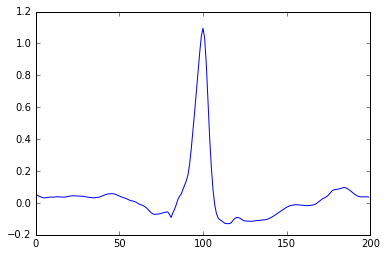

In [57]:
plt.plot(np.mean(N_ECG,axis=0))
plt.show()

# VFIB Beat

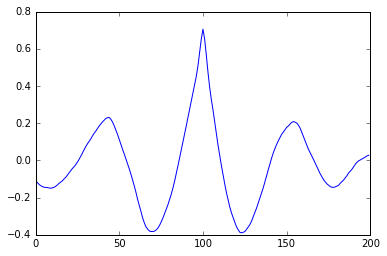

In [59]:
plt.plot(np.mean(V_ECG,axis=0))
plt.show()

In [58]:
# vfib_dict = {'N':N_ECG, 'V':V_ECG}
# jl.dump(vfib_dict, '../ecg_research/Databases/VFIB_database.pickle')

In [116]:
N_anns = np.array(['N'] * len(N_ECG))
V_anns = np.array(['V'] * len(V_ECG))

In [117]:
X = np.concatenate([N_ECG, V_ECG]) #shape
y = np.concatenate([N_anns, V_anns])

In [118]:
print(X.shape, y.shape)

(23034, 200) (23034,)


In [119]:
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)

In [120]:
# X_c = StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=.4, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [121]:
best_classifier = MLPClassifier((100, 100, 100))
best_classifier.fit(X_train, y_train)
score = best_classifier.score(X_test, y_test)
prediction = best_classifier.predict(X_test)

In [131]:
jl.dump(best_classifier, '../ecg_research/Classifiers/VFIB_Classifier.sav')

['../ecg_research/Classifiers/VFIB_Classifier.sav']

In [122]:
score

0.97178207076188405

# Test on Specific Patient (whole duration)

In [123]:
vfib_patient_dict = jl.load('../ecg_research/Databases/VFIB_patients.pickle')

In [124]:
vfib_patient_test = vfib_patient_dict['cu01']

In [125]:
ecg = vfib_patient_test
window = int(f * 0.4) #800ms beat
ecg_new = ecg_util.baseline_correct(ecg, f)
rpeaks = np.array(ecgsig.hamilton_segmenter(ecg_new, f)['rpeaks'])[2:-2] #detect rpeaks from ecg
beats = np.array([ecg_new[i - window: i + window] for i in rpeaks])
pca = PCA(n_components=10)
beats_new = pca.fit_transform(beats)

# Predicted as Normal

In [130]:
pred_pat = best_classifier.predict(beats_new)

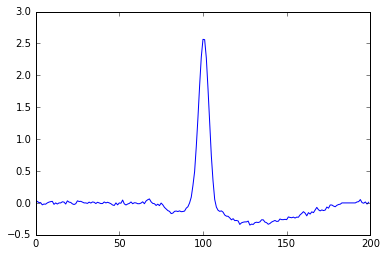

In [126]:
plt.plot(beats[np.where(pred_pat == '0')[0][0]])

# Predicted as Vfib

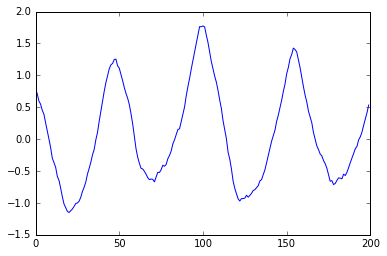

In [127]:
plt.plot(beats[np.where(pred_pat == '1')[0][0]])